In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import glob
import re
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import tensorflow as tf
import keras
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import gzip
import sys

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

2023-12-20 20:40:28.621146: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 20:40:28.621201: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 20:40:28.622564: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 20:40:28.725733: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 20:40:30.038817: W tensorflow/compiler/tf2t

# LCC Data Import

In [2]:
# Import lcc data files for wt protein and assign to variable (wt_windowsize)
# Note if wt_filtered_lcc_[]_[].lccdata files have already been generated, this code will not work.
wt_files=glob.glob('w*.lccdata')
wt_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))  # Sort files based on numerical part

window_range = list(range(2,51))
wt_dict = {}
for window, file in zip(window_range, wt_files):
    wt_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0) 
    
print(wt_files)

['wildtype_2.lccdata', 'wildtype_3.lccdata', 'wildtype_4.lccdata', 'wildtype_5.lccdata', 'wildtype_6.lccdata', 'wildtype_7.lccdata', 'wildtype_8.lccdata', 'wildtype_9.lccdata', 'wildtype_10.lccdata', 'wildtype_11.lccdata', 'wildtype_12.lccdata', 'wildtype_13.lccdata', 'wildtype_14.lccdata', 'wildtype_15.lccdata', 'wildtype_16.lccdata', 'wildtype_17.lccdata', 'wildtype_18.lccdata', 'wildtype_19.lccdata', 'wildtype_20.lccdata', 'wildtype_21.lccdata', 'wildtype_22.lccdata', 'wildtype_23.lccdata', 'wildtype_24.lccdata', 'wildtype_25.lccdata', 'wildtype_26.lccdata', 'wildtype_27.lccdata', 'wildtype_28.lccdata', 'wildtype_29.lccdata', 'wildtype_30.lccdata', 'wildtype_31.lccdata', 'wildtype_32.lccdata', 'wildtype_33.lccdata', 'wildtype_34.lccdata', 'wildtype_35.lccdata', 'wildtype_36.lccdata', 'wildtype_37.lccdata', 'wildtype_38.lccdata', 'wildtype_39.lccdata', 'wildtype_40.lccdata', 'wildtype_41.lccdata', 'wildtype_42.lccdata', 'wildtype_43.lccdata', 'wildtype_44.lccdata', 'wildtype_45.lccda

In [3]:
# Import lcc data files for mutant protein and assign to variable (mutant_windowsize)
m_files = glob.glob('m*.lccdata')
m_files.sort(key=lambda x: [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', x)])

window_range = list(range(2, 51))
D132H_dict = {}
for window, file in zip(window_range, m_files):
    D132H_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0)
    
print(m_files)

['myc_091-160_D132-H_2.lccdata', 'myc_091-160_D132-H_3.lccdata', 'myc_091-160_D132-H_4.lccdata', 'myc_091-160_D132-H_5.lccdata', 'myc_091-160_D132-H_6.lccdata', 'myc_091-160_D132-H_7.lccdata', 'myc_091-160_D132-H_8.lccdata', 'myc_091-160_D132-H_9.lccdata', 'myc_091-160_D132-H_10.lccdata', 'myc_091-160_D132-H_11.lccdata', 'myc_091-160_D132-H_12.lccdata', 'myc_091-160_D132-H_13.lccdata', 'myc_091-160_D132-H_14.lccdata', 'myc_091-160_D132-H_15.lccdata', 'myc_091-160_D132-H_16.lccdata', 'myc_091-160_D132-H_17.lccdata', 'myc_091-160_D132-H_18.lccdata', 'myc_091-160_D132-H_19.lccdata', 'myc_091-160_D132-H_20.lccdata', 'myc_091-160_D132-H_21.lccdata', 'myc_091-160_D132-H_22.lccdata', 'myc_091-160_D132-H_23.lccdata', 'myc_091-160_D132-H_24.lccdata', 'myc_091-160_D132-H_25.lccdata', 'myc_091-160_D132-H_26.lccdata', 'myc_091-160_D132-H_27.lccdata', 'myc_091-160_D132-H_28.lccdata', 'myc_091-160_D132-H_29.lccdata', 'myc_091-160_D132-H_30.lccdata', 'myc_091-160_D132-H_31.lccdata', 'myc_091-160_D132

# 1.1 RF Model and Feature Importance

In [4]:
# Build and train random forest classifier with selected hyperparameters + extract feature importance
def RFC(window, wt, mutant):

    # Add labels
    wt_label = np.zeros(len(wt))
    mutant_label = np.ones(len(mutant))
    
    # Concatenate data frames and label arrays
    X_train_full = pd.concat([wt, mutant])
    y_train_full = np.concatenate((wt_label, mutant_label))
    
    # Separate training and validation sets and print relevant shapes
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.2)
    
    # Build random forest classifier
    rnd_clf = RandomForestClassifier(n_estimators = 400, max_leaf_nodes = 32, n_jobs=-1)
    
    # Fit rf model
    rnd_clf.fit(X_train, y_train)
    
    # Perform predictions on validation set
    y_pred_rf = rnd_clf.predict(X_valid)
    
    # Evaluate model accuracy
    accuracy = accuracy_score(y_valid, y_pred_rf)
    
    confusion = confusion_matrix(y_valid, y_pred_rf)
    
    # Extract importance of each position
    position = []
    importance = []
    
    for name, score in zip(X_train.columns, rnd_clf.feature_importances_):
        position.append(name)
        importance.append(score)
    
    upper_limit = 70 + 1 - window # max protein length + 1
    
    x = np.arange(1 + window / 2 ,upper_limit + window / 2) + 90
    
    rf_pos_importance = pd.DataFrame({'Position': x, 'Importance:': importance})
    
    rf_pos_importance.to_csv('pos_imp'+str(window)+'.csv')
    
    return accuracy, confusion, rf_pos_importance

-------------------- Tester results --------------------
Window size = 12
Accuracy =  0.877875 

Confusion matrix:


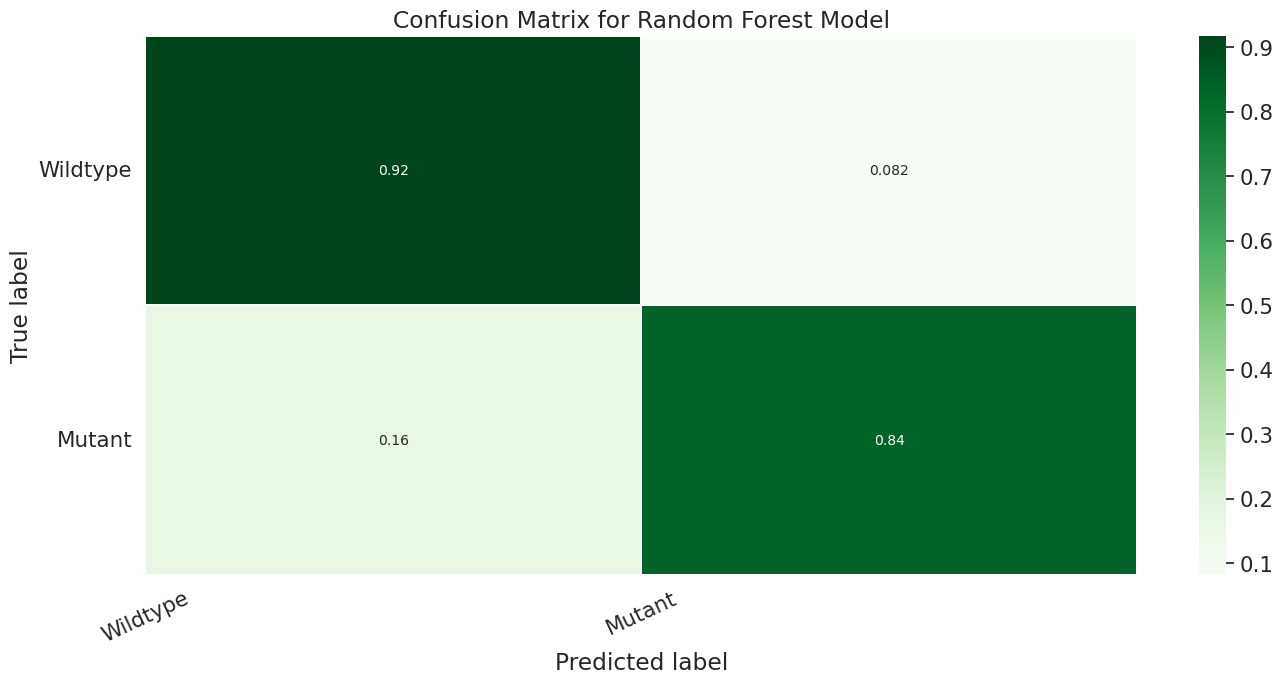



Results dataframe:


,Position,Importance:
0,97.0,0.002108
1,98.0,0.003067
2,99.0,0.003278
3,100.0,0.005008
4,101.0,0.016202


In [5]:
# Testing random forest classifier for window = 12
acc_12_test, conf_12_test, rf_wt_12_test = RFC(12, wt_dict[12], D132H_dict[12])

print('-------------------- Tester results --------------------')
print('Window size = 12')
print('Accuracy = ', acc_12_test, '\n')
print('Confusion matrix:')

conf_12_test = conf_12_test.astype('float') / conf_12_test.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(conf_12_test, annot=True, annot_kws={'size':10}, cmap=plt.cm.Greens, linewidths=0.2)
class_names = ['Wildtype', 'Mutant']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

print('\n')
print('Results dataframe:')
display(rf_wt_12_test.head())

In [6]:
## function for data filtering at different levels

def filter_lcdata(window, rf_data, wt, D132H, level):
    
    ''' Filters local compaction data according to feature importance'''
    
    # Calculate max importance
    max_rf_imp = rf_data['Importance:'].max()
    
    # Determine threshold according to filtering level
    threshold = ((max_rf_imp/100)*level)
    
    # Determine positions to keep
    rf_filtered = rf_data[rf_data['Importance:'] > threshold]
    
    idx_keep = rf_filtered.index.values.tolist()
    
    index_keep = [int(i) for i in idx_keep]
    
    # Drop "irrelevant" positions
    filtered_wt = wt[index_keep]

    filtered_D132H = D132H[index_keep]
    
    # Filtered data to csv
    filtered_wt.to_csv(path_or_buf="wt_filtered_lcc_" + str(window) + "_" + str(level) + ".lccdata", sep='\t', mode='w')
    
    filtered_D132H.to_csv(path_or_buf="D132H_filtered_lcc_" + str(window)  + "_" + str(level) + ".lccdata", sep='\t', mode='w')
    
    return filtered_wt, filtered_D132H, index_keep

In [8]:
# Initializing dictionaries
acc_dict = {}
rf_dict = {}
conf_mat = {}
n_sim = 10

# Running random forest analysis for all ws
for window in tqdm(window_range):
        
    acc_dict[window], conf_mat[window], rf_dict[window] = RFC(window, wt_dict[window], D132H_dict[window])

100%|███████████████████████████████████████████| 49/49 [11:56<00:00, 14.62s/it]


In [9]:
filt_3_wt, filt_3_m, idx3 = filter_lcdata(3, rf_dict[3], wt_dict[3], D132H_dict[3], 50)
filt_12_wt, filt_12_m, idx12 = filter_lcdata(12, rf_dict[12], wt_dict[12], D132H_dict[12], 50)
filt_20_wt, filt_20_m, idx20 = filter_lcdata(20, rf_dict[20], wt_dict[20], D132H_dict[20], 50)

Number of trajectory frames read in:  40000


<Figure size 640x480 with 0 Axes>

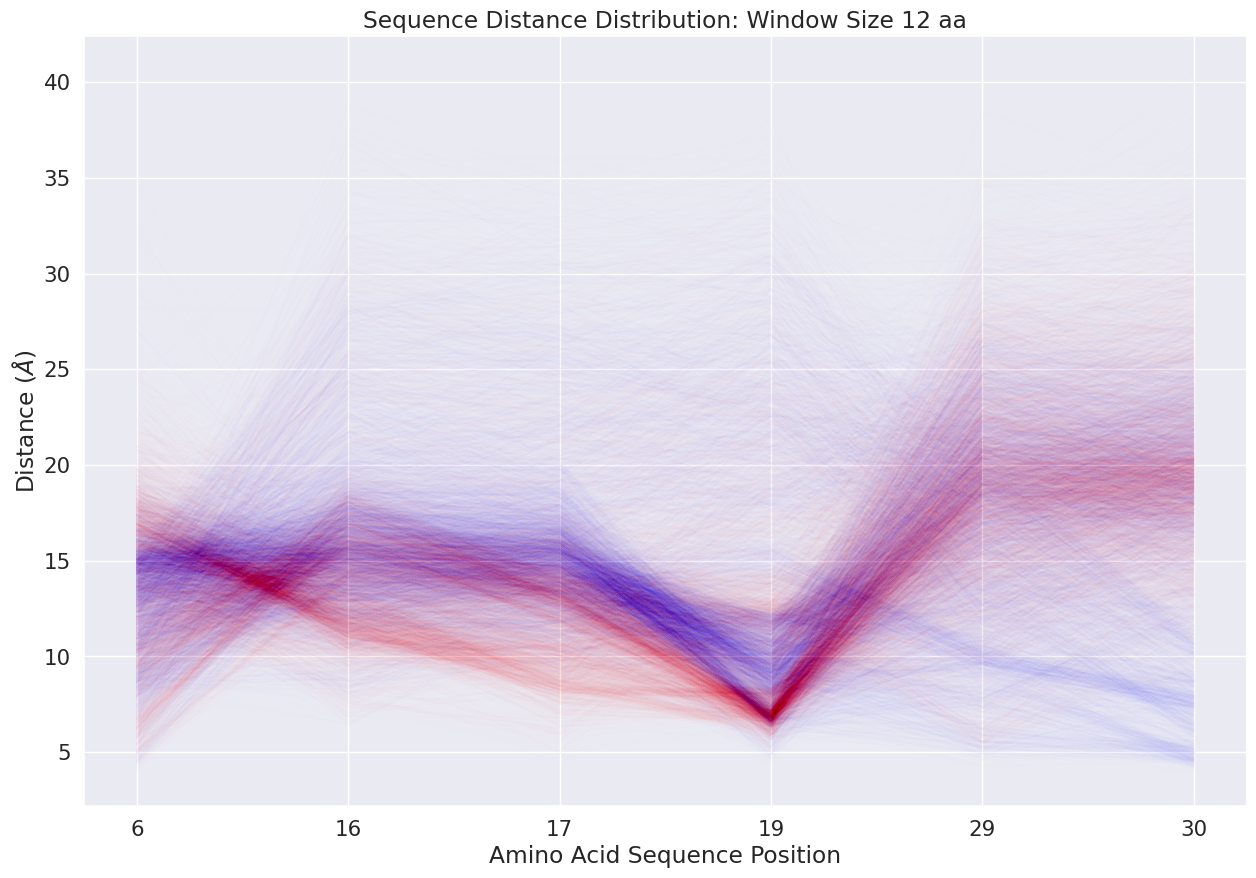

In [10]:
# Plots filtered LC data for ws 12

filtered_train_test_12_wt_np  = filt_12_wt.to_numpy()
filtered_train_test_D132H_12_np  = filt_12_m.to_numpy()
window = 12
frame_number = filtered_train_test_12_wt_np.shape[0] #get the number of frames read
print ("Number of trajectory frames read in: ", frame_number)
x = [str(i) for i in idx12]
plt.clf()
plt.figure(figsize=(15,10))
plt.xlabel('Amino Acid Sequence Position')  
plt.ylabel('Distance ($\AA$)')  #Angstrom
#plt.xticks(x)
plot_name = 'Sequence Distance Distribution: Window Size ' + str(window) + ' aa'
plt.title(plot_name) 
for z in range (1,frame_number,10):
    y=filtered_train_test_12_wt_np[z] #read row for distances along primary sequence    
    plt.plot(x,y, color = 'blue', alpha=0.002) #avoid reading header in y
    k=filtered_train_test_D132H_12_np[z]
    plt.plot(x,k, color = 'red', alpha=0.002)
    

figure_name = "filtered_data_local_compaction_plot_" + str(window) + ".png"
plt.savefig(figure_name, dpi = 300)

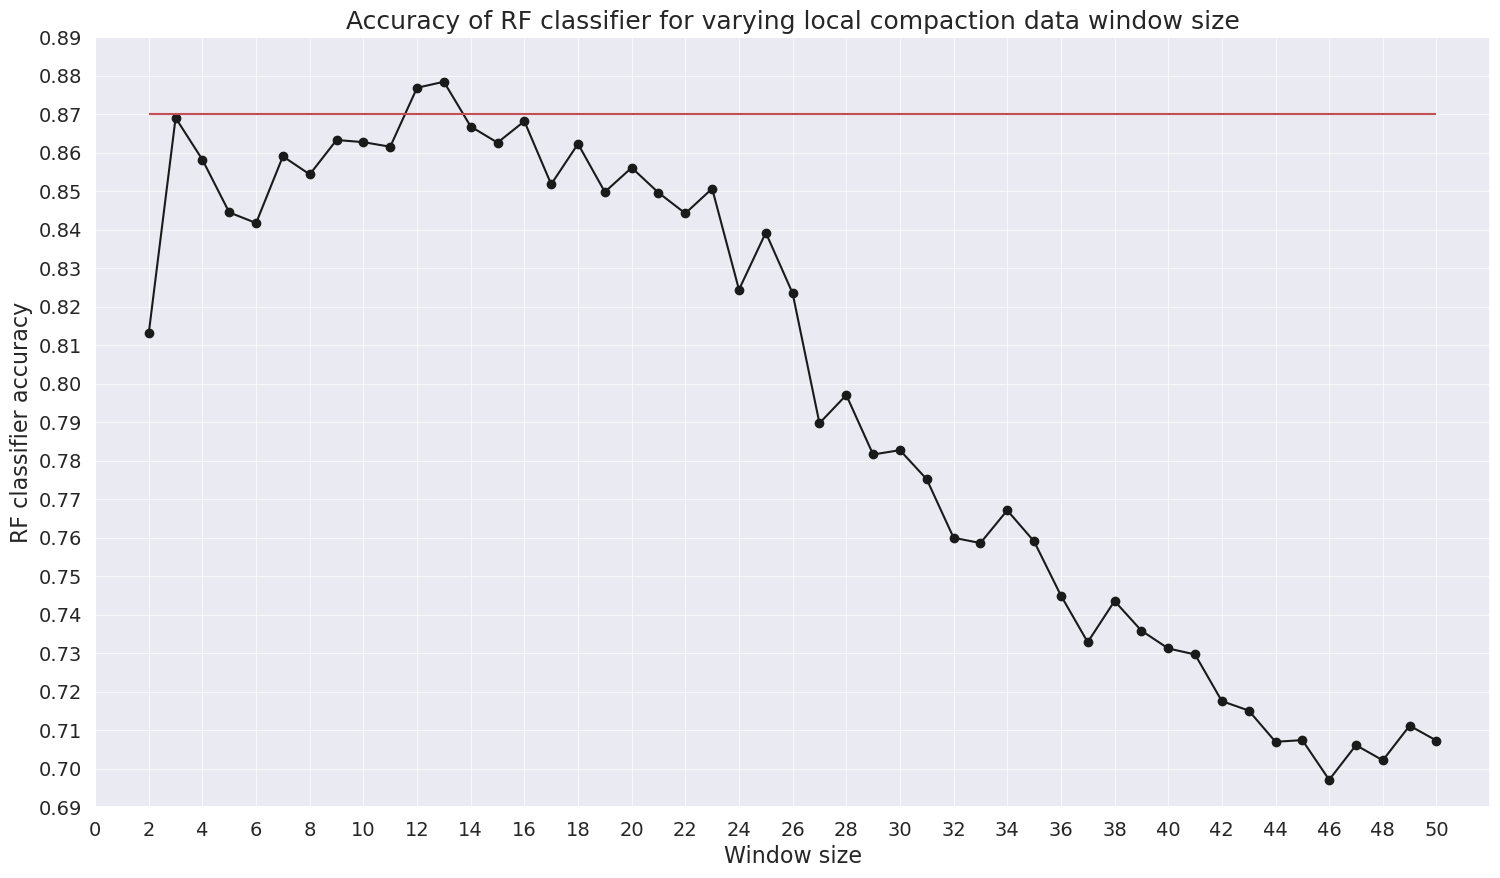

In [11]:
# Plot random forest classification accuracy at varying ws
ws = range(2,51)
plt.figure(figsize=(18,10))
plt.plot(list(acc_dict.keys()), list(acc_dict.values()), 'k-o')
plt.xlim()
plt.grid(which='both', linewidth=0.5)
plt.title('Accuracy of RF classifier for varying local compaction data window size', fontsize=18)
plt.xlabel('Window size', fontsize=16)
plt.ylabel('RF classifier accuracy', fontsize=16)
plt.xlim(1,52)
plt.ylim(0.69,0.89)
plt.xticks(np.arange(0,51,2), fontsize=14)
plt.yticks(np.arange(0.69,0.89, 0.01), fontsize=14)
plt.hlines(0.87,2,50,colors='r', label = 'Threshold')
plt.savefig('Accuracy at diff ws_7.png', dpi =300)
plt.show()

Text(0, 0.5, 'Compression ratio')

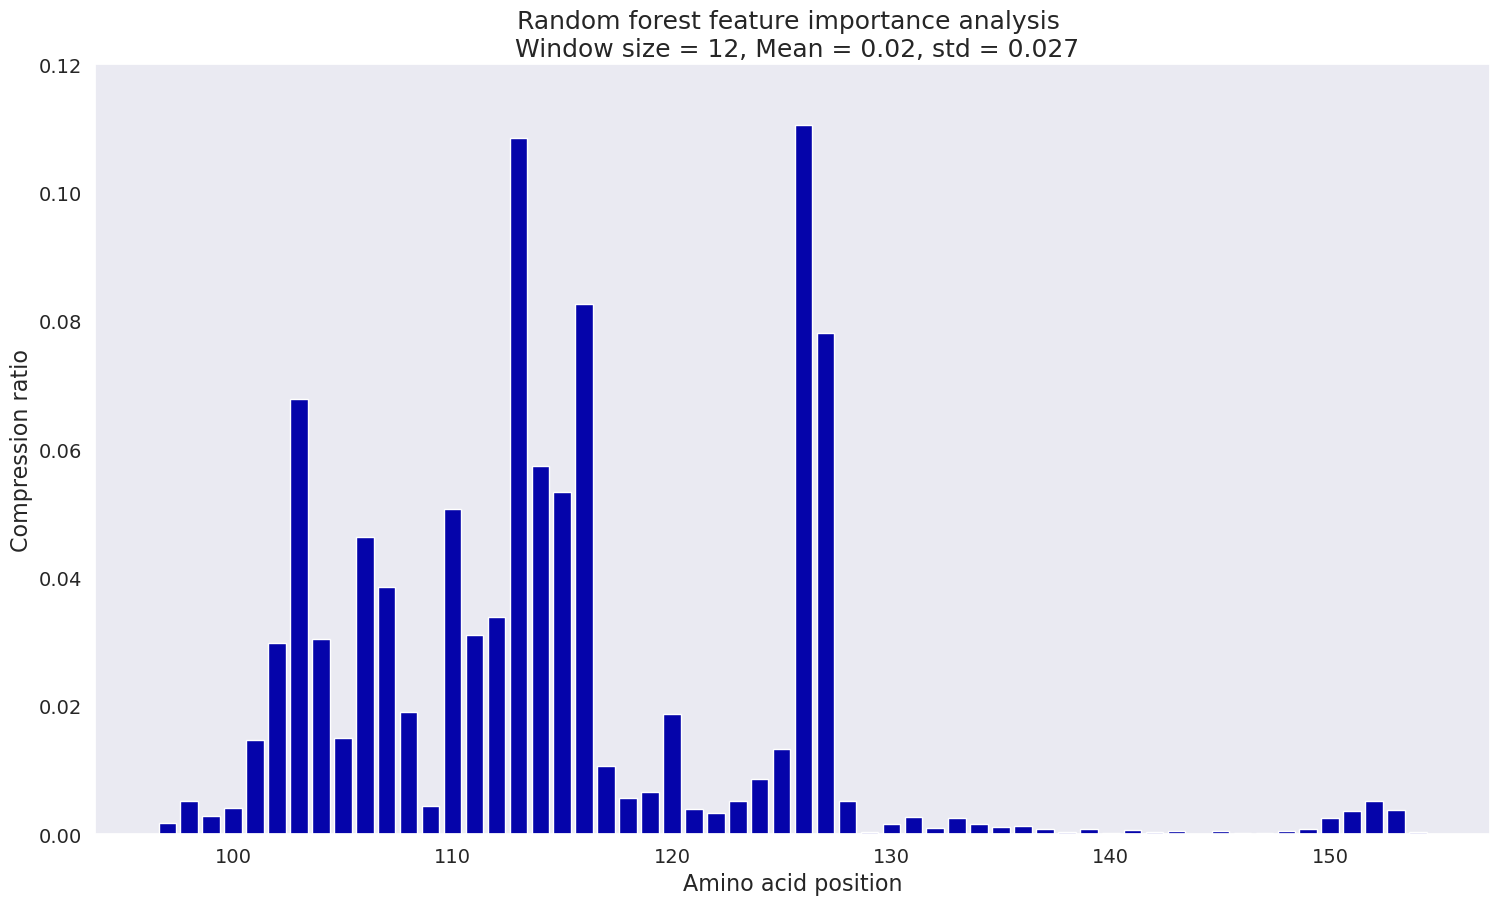

In [12]:
# Feature importance plot for ws 12
plt.figure(figsize=(18,10))
yrf = rf_dict[12]['Importance:'].values
mean2 = np.mean(yrf)
std2 = np.std(yrf)
plt.bar(rf_dict[12]['Position'], yrf, color='#0504aa')
plt.title('Random forest feature importance analysis \n Window size = {}, Mean = {}, std = {}'.format(12, np.round(mean2,2), np.round(std2,3)), fontsize = 18)
plt.ylim(0,0.12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.xlabel('Amino acid position', fontsize = 16)
plt.ylabel('Compression ratio', fontsize = 16)

100%|███████████████████████████████████████████| 48/48 [00:01<00:00, 24.08it/s]


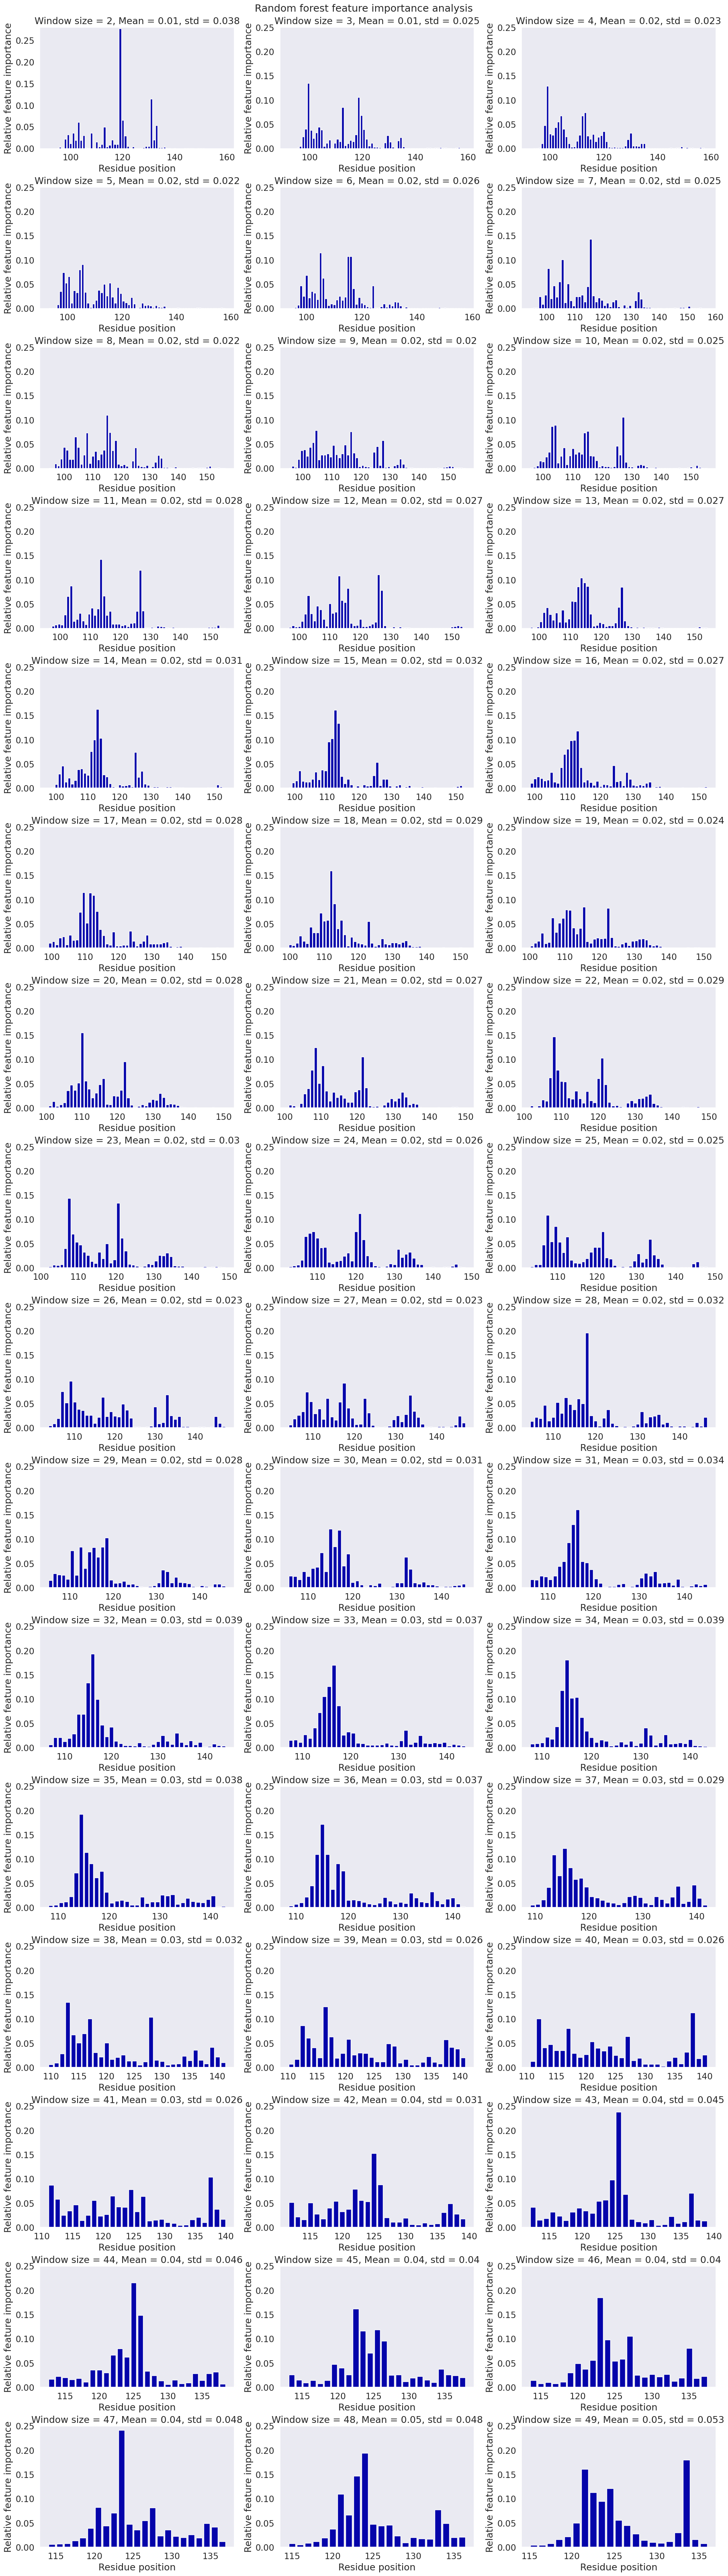

In [13]:
# Plot feature importance for each window size
fig, ax = plt.subplots(16,3, figsize=(18,4*16), constrained_layout=True)

for i in tqdm(range(48)):
    yyrf = (rf_dict[i+2]['Importance:'].values)
    meanrf = np.mean(yyrf)
    stdrf = np.std(yyrf)
    ax[i//3][i%3].bar(rf_dict[i+2]['Position'], yyrf, color='#0504aa')
    ax[i//3][i%3].set_title('Window size = {}, Mean = {}, std = {}'.format(i+2, np.round(meanrf,2), np.round(stdrf,3)))
    ax[i//3][i%3].grid()
    ax[i//3][i%3].set_xlabel('Residue position')
    ax[i//3][i%3].set_ylabel('Relative feature importance')
    ax[0][0].set_ylim(0,0.28)
    ax[i//3][i%3].set_ylim(0,0.25)
    
#plt.supylabel("Feature importance")
plt.suptitle("Random forest feature importance analysis", fontsize=18)
#plt.supxlabel("Position")

plt.show()

In [14]:
# Cross validation for hyperparameter tuning
def RF_classifier(window, wt, mutant):

    ''' 
    Build RF classifier, than perform cross validation to select best parameters
    '''
    
    # Add labels
    wt_label = np.zeros(len(wt))
    mutant_label = np.ones(len(mutant))
    
    # Concatenate data frames and label arrays
    X_train_full = pd.concat([wt, mutant])
    y_train_full = np.concatenate((wt_label, mutant_label))
    
    # Separate training and validation sets and print relevant shapes
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, stratify=y_train_full, test_size=0.2)
    
    print('Window size:', str(window))
    print(X_train.shape)
    print(X_valid.shape)
    print(y_train.shape)
    print(y_valid.shape)
    
    # Define parameter range
    
    parameters = {
    "n_estimators":[100,250,500],
    "max_depth":[16,32,64]
    }
    
    rfc = RandomForestClassifier()
    
    # Perform cross validation to determine best parameters
    cv = GridSearchCV(rfc,parameters,cv=5, verbose=1)
    
    cv.fit(X_train, y_train)
    
    def display(results):
        print(f'Best parameters are: {results.best_params_}')
        print("\n")
        mean_score = results.cv_results_['mean_test_score']
        std_score = results.cv_results_['std_test_score']
        params = results.cv_results_['params']
        for mean,std,params in zip(mean_score,std_score,params):
            print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')
            
    display(cv)

In [ ]:
pd.read_csv()